1. In the first exercise you will design a simpler variant of LODA. First you will generate a 2D dataset that follows a standard normal distribution (500 points) using sklearn.datasets.make blobs.
2. Then you will randomly generate 5 unit-length projection vectors (you can use numpy.random.multivariate normal with (0, 0) mean and identity matrix as covariance matrix) that will be used to generate 1D histograms (for the projected values). You will compute the corresponding histograms with equal-width bins using numpy.histogram (for the range parameter use a larger interval than the range of the projected values). For each histogram compute the probability corresponding to each bin and use them to compute the anomaly score of a sample as the mean of the probabilities (corresponding to each histogram).
3. For testing, generate a dataset with 500 points from a uniform distribution (between-3 and 3 using np.random.uniform). Plot the points in the test dataset using a colormap (related to the anomaly scores). 
4. Use different number of bins and see how this affects the score map.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from pyod.utils.utility import standardizer
from sklearn.datasets import make_blobs
from pyod.models.loda import LODA
from pyod.models.iforest import IForest
from deepod.models.tabular import DeepIsolationForest as DIF

ModuleNotFoundError: No module named 'deepod'

In [79]:
pip install deepod torch

  Using cached deepod-0.4.1-py3-none-any.whl.metadata (10 kB)
  Using cached torch-2.9.0-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (30 kB)
INFO: pip is looking at multiple versions of deepod to determine which version is compatible with other requirements. This could take a while.
  Using cached deepod-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached deepod-0.3.0-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached deepod-0.2.0-py3-none-any.whl.metadata (3.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manyl

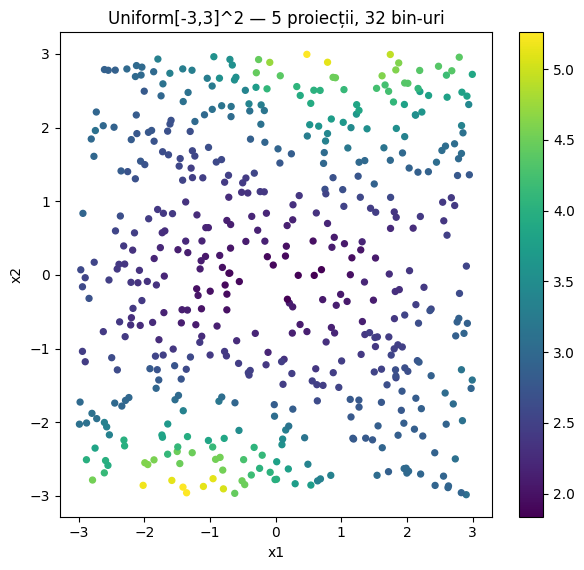

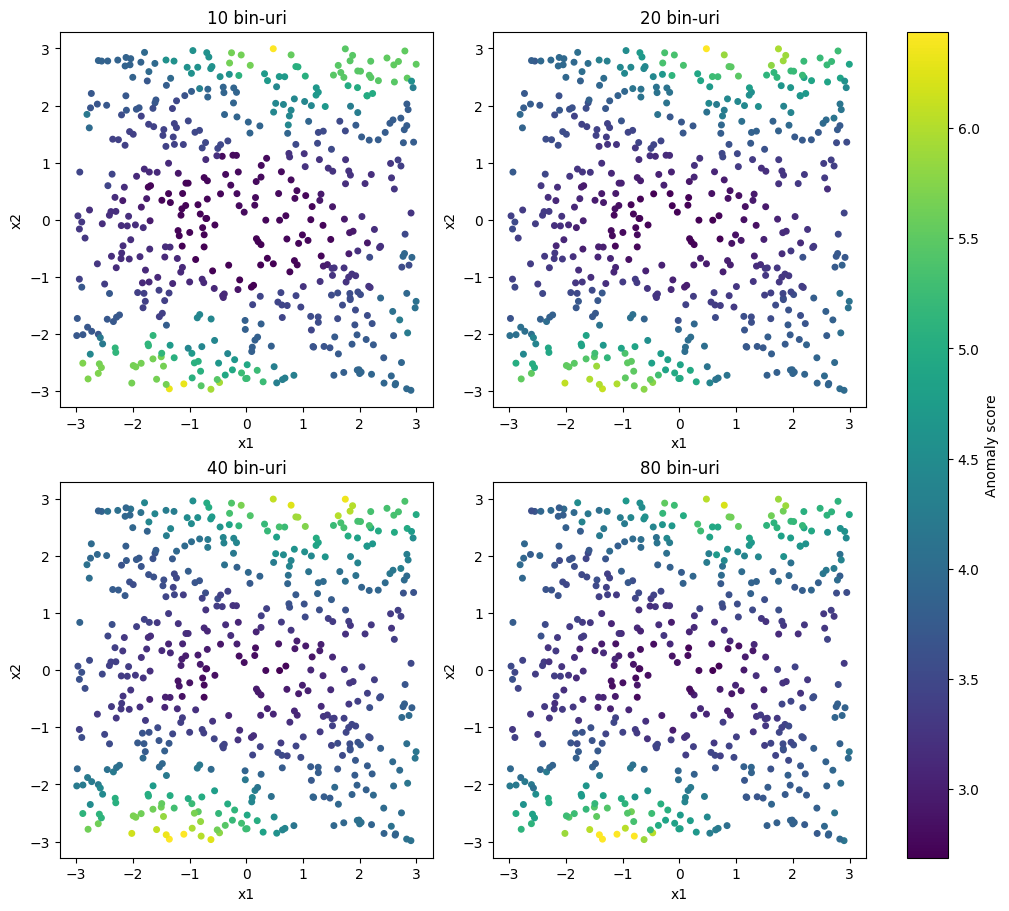

In [ ]:

rng = np.random.default_rng(42)
k = 5
d = 2
eps = 1e-12


V = rng.normal(size=(k, d))
V /= np.linalg.norm(V, axis=1, keepdims=True)


n_bins = 32
H_range = (-6, 6)
H_probs = []
H_edges = []

for v in V:
    z = X @ v
    counts, edges = np.histogram(z, bins=n_bins, range=H_range, density=True)
    bin_w = edges[1] - edges[0]
    probs = counts * bin_w                 
    H_probs.append(probs)
    H_edges.append(edges)


X_test = np.random.default_rng(1).uniform(-3, 3, size=(500, 2))

s_mean = np.zeros(X_test.shape[0])
for v, probs, edges in zip(V, H_probs, H_edges):
    zt = X_test @ v
    idx = np.searchsorted(edges, zt, side="right") - 1
    idx = np.clip(idx, 0, len(probs) - 1)
    s_mean += probs[idx]
s_mean /= k
s_anom = -np.log(s_mean + eps)             

plt.figure(figsize=(6.2, 5.8))
sc = plt.scatter(X_test[:,0], X_test[:,1], c=s_anom, s=18)
plt.colorbar(sc)
plt.title("Uniform[-3,3]^2 — 5 proiecții, 32 bin-uri")
plt.xlabel("x1"); plt.ylabel("x2"); plt.tight_layout()
plt.show()
bins_list = [10, 20, 40, 80]
fig, axs = plt.subplots(2, 2, figsize=(10, 9), constrained_layout=True)

for ax, nb in zip(axs.ravel(), bins_list):
  
    H_probs2 = []
    H_edges2 = []
    for v in V:
        z = X @ v
        counts, edges = np.histogram(z, bins=nb, range=H_range, density=True)
        bin_w = edges[1] - edges[0]
        probs = counts * bin_w
        H_probs2.append(probs)
        H_edges2.append(edges)

    
    s_mean2 = np.zeros(X_test.shape[0])
    for v, probs, edges in zip(V, H_probs2, H_edges2):
        zt = X_test @ v
        idx = np.searchsorted(edges, zt, side="right") - 1
        idx = np.clip(idx, 0, len(probs) - 1)
        s_mean2 += probs[idx]
    s_mean2 /= k
    s2 = -np.log(s_mean2 + eps)

    sc = ax.scatter(X_test[:,0], X_test[:,1], c=s2, s=16)
    ax.set_title(f"{nb} bin-uri")
    ax.set_xlabel("x1"); ax.set_ylabel("x2")

fig.colorbar(sc, ax=axs.ravel().tolist(), label="Anomaly score")
plt.show()


In [ ]:
pip install torch

In [77]:
X_train, _ = make_blobs(n_samples=[500, 500],  centers=[(10, 0), (0, 10)],cluster_std=1.0, random_state=0)
rng = np.random.default_rng(1)
X_test=rng.uniform(-10,20,size=(1000,2))
Xtr,Xte=standardizer(X_train,X_test)
iforest = IForest(n_estimators=200,max_samples=256,contamination=0.02,random_state=0)
iforest.fit(Xtr)
s_if = iforest.decision_function(Xte)
loda = LODA(n_bins="auto")
loda.fit(Xtr)
s_loda=loda.decision_function(Xte)
dif = DIF(epochs=20, hidden_dims=(64, 32), random_state=0)
dif.fit(Xtr)
s_dif = dif.decision_function(Xte)
has_dif = True



NameError: name 'DIF' is not defined